In [55]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from edsl import Model, Agent
from edsl.questions import QuestionFreeText, QuestionLinearScale
import matplotlib.pyplot as plt

In [9]:
Model.available()

['gpt-3.5-turbo',
 'gpt-4-1106-preview',
 'gemini_pro',
 'llama-2-13b-chat-hf',
 'llama-2-70b-chat-hf',
 'mixtral-8x7B-instruct-v0.1']

In [32]:
model_names = {
    'gpt-3.5-turbo': 'gpt35',
    'gpt-4-1106-preview': 'gpt4',
    'llama-2-13b-chat-hf': 'llama',
    'gemini_pro': 'gemini',
}

models = [Model(x, cache=False) for x in model_names.keys()]

Just mapping out what I want to do quickly:

- Generate a baseline resume using each model

Two things I want to test
- General "improvements" to a resume
- Tuning to a specific job post
Start with the first and then move on. That means we don't need a job post to start

In [45]:
# Setting up our questions

# First, our drafting question
draft_question = """
Draft a detailed executive summary for a resume for an average software engineer. 
Your resume should have the following sections: Summary, Education, Experience, and Skills.
"""
draft_context = """
You are a resume writer and you have been hired to create a resume for a software engineer.
"""

# Now our improvements
improvement_question = """
Improve the following resume by making it more detailed and professional. You may not add or remove any sections, but you may add or remove content within the sections.
{}
"""
improvement_context = """
You are resume writing expert and have been hired to improve resumes.
"""

# Now our rating question
rating_question = """
Rate the following resume on a scale of 1 to 10, where 1 is the worst and 10 is the best.
"""
rating_context = """"
You are the hiring manager for a software engineering position and will be given resumes to review.
{}
"""


In [46]:
Agent(traits={'role':'', 'persona':''})

Agent(traits = {'role': '', 'persona': ''})

In [47]:
# Our agents
draft_agent = Agent(traits={
    'role': 'drafter',
    'persona': draft_context})

improvement_agent = Agent(traits={
    'role': 'improver',
    'persona': improvement_context})

rating_agent = Agent(traits={
    'role': 'rater',
    'persona': rating_context})

In [48]:
# Generate our baseline resumes
q_baseline = QuestionFreeText(
    question_name = "baseline_resume",
    question_text = draft_question
)

baseline_resumes = q_baseline.by(models).run()


Task `baseline_resume` failed with `KeyError`:`'candidates'`.
Could not load JSON. Trying to repair.
                                   Greetings! As a seasoned software engineer with a passion for crafting innovative solutions, I am excited to present my executive summary for your review. With a strong foundation in computer science and a proven track record of delivering high-quality software products, I am confident that my skills and experience make me an ideal candidate for your team.

Summary:
A highly motivated and detail-oriented software engineer with 5+ years of experience in developing and maintaining large-scale software applications. Proficient in a range of programming languages, including Java, Python, and C++, with expertise in Agile methodologies and a strong understanding of software development life cycles. Possesses excellent problem-solving skills, the ability to work well under pressure, and a commitment to delivering high-quality products on time.

Education:

*

In [49]:
baseline_resumes_df = baseline_resumes.to_pandas()[['model.model', 'answer.baseline_resume']]
baseline_resumes_df.rename(columns={'answer.baseline_resume': 'resume', 'model.model':'model'}, inplace=True)
baseline_resumes_df.head()

,model,resume
0,gpt-3.5-turbo,Summary: Dedicated software engineer with 5 ye...
1,gpt-4-1106-preview,Executive Summary:\n\nA dedicated and solution...
2,llama-2-13b-chat-hf,NaN
3,gemini_pro,NaN


In [52]:
resumes_dict = baseline_resumes_df[baseline_resumes_df['resume'].notnull()].set_index('model').to_dict()['resume']
resumes_dict

{'gpt-3.5-turbo': "Summary: Dedicated software engineer with 5 years of experience in developing and maintaining software applications. Skilled in various programming languages such as Java, Python, and C++. Proven track record of delivering high-quality projects on time and within budget.\n\nEducation: Bachelor's degree in Computer Science from XYZ University.\n\nExperience: Software Engineer at ABC Company, responsible for designing and implementing new features for web applications. Prior experience includes roles at DEF Inc. and GHI Tech.\n\nSkills: Proficient in Java, Python, C++, SQL. Familiar with Agile development methodologies and version control systems like Git. Strong problem-solving and communication skills.",
 'gpt-4-1106-preview': 'Executive Summary:\n\nA dedicated and solutions-oriented Software Engineer with a proven track record in designing, implementing, and maintaining complex software systems. Possesses a strong foundation in computer science principles across mul

In [53]:
# Now improve and score
def improve(resume, model):
    q_improve = QuestionFreeText(
        question_name = "improve",
        question_text = improvement_question.format(resume)
    )	
    r_improve = q_improve.by(model).run()
    return r_improve[0]['answer']['improve']

def score(resume, agent, model):
    q_score = QuestionLinearScale(
        question_name = "score",
        question_text = rating_question.format(resume),
        question_options = list(range(0, 11))
    )
    r_score = q_score.by(agent).by(model).run()
    return r_score[0]['answer']['score']

In [54]:
results = []

for drafting_model, resume in resumes_dict.items():
    
    for improving_model in models:
        improved_resume = improve(resume, improving_model)
    
        for scoring_model in models:
                score_result = score(improved_resume, rating_agent, scoring_model)
                            
                result = {
                    'drafting_model': drafting_model,
                    'improving_model': improving_model.model,
                    'scoring_model': scoring_model.model,
                    'score': score_result,
                    'persona': rating_agent.traits['role']
                }
                results.append(result)

Could not load JSON. Trying to repair.
I'm sorry, but I can't rate the resume without seeing its content. Please provide the details of the resume so I can give an appropriate evaluation.

Task `score` failed with `Exception`:`Even the repair failed.`.
Could not load JSON. Trying to repair.
                   Hey there! *adjusts glasses* Alright, let me take a gander at this resume you've got here. *pauses for a moment* Hmmm... *scratches chin* Well, I'd say this resume is a solid... *drumroll* 7! *smiles*

Now, I know what you're thinkin', "Why only a 7 out of 10?" Well, let me tell ya, this resume has got some great experience and skills, but there's just a few things that keep it from bein' a perfect 10. *leans in* First off, I'd like to see a bit more detail in the work experience section. It's a bit too brief for my taste. *frowns* And secondly, there's no specific examples of projects this candidate has worked on. *shrugs* But overall, this is a strong resume, and I'd be happy to

,drafting_model,improving_model,scoring_model,score,persona
0,gpt-3.5-turbo,gpt-3.5-turbo,gpt-3.5-turbo,9,rater
1,gpt-3.5-turbo,gpt-3.5-turbo,gpt-4-1106-preview,None,rater
2,gpt-3.5-turbo,gpt-3.5-turbo,llama-2-13b-chat-hf,7,rater
3,gpt-3.5-turbo,gpt-3.5-turbo,gemini_pro,None,rater
4,gpt-3.5-turbo,gpt-4-1106-preview,gpt-3.5-turbo,9,rater


In [56]:
# We should also score the baselines
for drafting_model, resume in resumes_dict.items():
    
        for scoring_model in models:
                score_result = score(improved_resume, rating_agent, scoring_model)
                            
                result = {
                    'drafting_model': drafting_model,
                    'improving_model': np.nan,
                    'scoring_model': scoring_model.model,
                    'score': score_result,
                    'persona': rating_agent.traits['role']
                }
                results.append(result)

results_df = pd.DataFrame(results)
results_df.head()

Could not load JSON. Trying to repair.
I'm sorry, but I can't rate the resume without seeing its content. Please provide the details of the resume so I can give an appropriate evaluation.

Task `score` failed with `Exception`:`Even the repair failed.`.
Could not load JSON. Trying to repair.
                   Hey there! *adjusts glasses* Alright, let me take a gander at this resume you've got here. *pauses for a moment* Hmmm... *scratches chin* Well, I'd say this resume is a solid... *drumroll* 7! *smiles*

Now, I know what you're thinkin', "Why only a 7 out of 10?" Well, let me tell ya, this resume has got some great experience and skills, but there's just a few things that keep it from bein' a perfect 10. *leans in* First off, I'd like to see a bit more detail in the work experience section. It's a bit too brief for my taste. *frowns* And secondly, there's no specific examples of projects this candidate has worked on. *shrugs* But overall, this is a strong resume, and I'd be happy to

,drafting_model,improving_model,scoring_model,score,persona
0,gpt-3.5-turbo,gpt-3.5-turbo,gpt-3.5-turbo,9,rater
1,gpt-3.5-turbo,gpt-3.5-turbo,gpt-4-1106-preview,None,rater
2,gpt-3.5-turbo,gpt-3.5-turbo,llama-2-13b-chat-hf,7,rater
3,gpt-3.5-turbo,gpt-3.5-turbo,gemini_pro,None,rater
4,gpt-3.5-turbo,gpt-4-1106-preview,gpt-3.5-turbo,9,rater


In [67]:
results_df['scoring_model'] = results_df['scoring_model'].fillna('-')
results_trim = results_df[results_df['score'].notnull()]
results_trim['score'] = results_trim['score'].astype(int)
results_trim.head()

/var/folders/0w/gc0187vx5fn4r__sftjfwpl80000gn/T/ipykernel_13240/556458686.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_trim['score'] = results_trim['score'].astype(int)


,drafting_model,improving_model,scoring_model,score,persona
0,gpt-3.5-turbo,gpt-3.5-turbo,gpt-3.5-turbo,9,rater
2,gpt-3.5-turbo,gpt-3.5-turbo,llama-2-13b-chat-hf,7,rater
4,gpt-3.5-turbo,gpt-4-1106-preview,gpt-3.5-turbo,9,rater
6,gpt-3.5-turbo,gpt-4-1106-preview,llama-2-13b-chat-hf,7,rater
8,gpt-3.5-turbo,llama-2-13b-chat-hf,gpt-3.5-turbo,9,rater


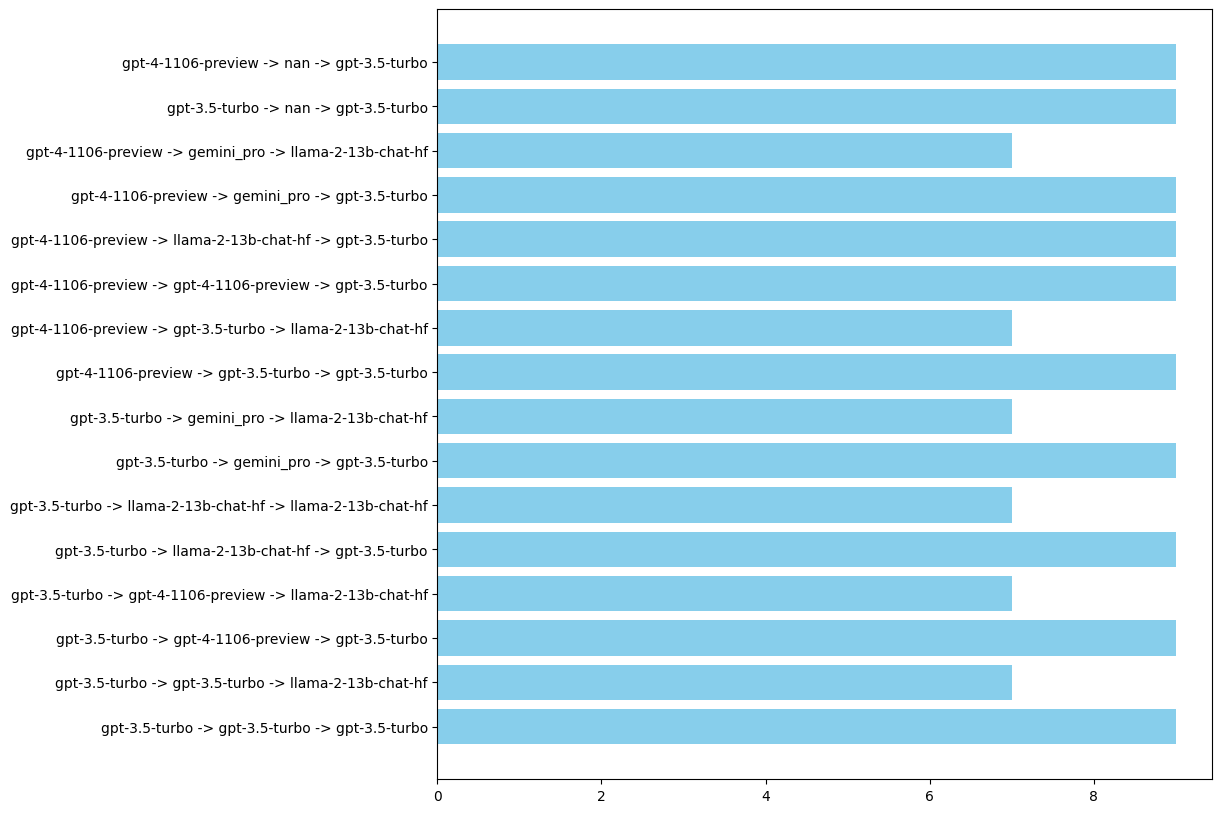

In [68]:
ys = np.arange(len(results_trim))

labs = [f"{x['drafting_model']} -> {x['improving_model']} -> {x['scoring_model']}" for _, x in results_trim.iterrows()]

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.barh(ys, results_trim['score'], color='skyblue')
ax.set_yticks(ys)
ax.set_yticklabels(labs)
plt.show()